# The Impact of News Event on Financial Markets

## Introduction

This project presents an event study analysis examining the impact of three key economic indicators (Consumer Price Index (CPI), Interest Rate, and Unemployment Rate) on the returns of the FTSE 100 index. The analysis is conducted over multiple event window sizes to provide a comprehensive understanding of short-term effects.

## 1. Setup and Data Preparation

### Import required libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os
from IPython.display import display, HTML

# Set the Seaborn style for all plots
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Custom colour palette
indicator_colour_palette = sns.color_palette("deep", 3)

# Ensure the directory exists before saving the data
output_directory = "data"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

### 1.1. Fetch FTSE 100 data

Retrieved 10 years of FTSE 100 data from Yahoo! Finance using the yfinance library and saved to a CSV file for later use.

Yahoo Finance FTSE 100 index: [https://uk.finance.yahoo.com/quote/%5EFTSE/](https://uk.finance.yahoo.com/quote/%5EFTSE/)

yfinance API: [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/)

In [ ]:
# Fetch FTSE 100 data for the last 10 years using the yfinance library
ftse100_ticker = yf.Ticker("^FTSE")
ftse100_historical_data = ftse100_ticker.history(period="10y")

# Display the first few rows of the fetched data
print(ftse100_historical_data.head())

# Save the FTSE 100 data to a CSV file
ftse100_historical_data.to_csv(os.path.join(output_directory, "ftse100_historical_data.csv"))

### 1.2. Load and process economic indicator dates

Publication dates of the economic indicators are loaded from the CSV file and processed for the analysis.

In [2]:
# Load indicator release dates from a CSV file
indicator_release_dates = pd.read_csv('data/dates.csv')

# Convert the 'Release Date' column to a datetime object
indicator_release_dates['Release Date'] = pd.to_datetime(indicator_release_dates['Release Date'], utc=True)
indicator_release_dates['Release Date'] = indicator_release_dates['Release Date'].dt.date

# Split the dataset into separate DataFrames based on 'Indicator' values
interest_rate_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'Interest Rate']
cpi_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'CPI']
unemployment_rate_release_dates = indicator_release_dates[indicator_release_dates['Indicator'] == 'Unemployment Rate']

# Save each indicator's release dates to separate CSV files
interest_rate_release_dates.to_csv('data/interest_rate_release_dates.csv', index=False)
cpi_release_dates.to_csv('data/cpi_release_dates.csv', index=False)
unemployment_rate_release_dates.to_csv('data/unemployment_rate_release_dates.csv', index=False)

### 1.3. Load and process FTSE 100 data

Previously saved raw data is loaded and processed for the analysis.

In [3]:
# Load the saved FTSE 100 data from the CSV file
ftse100_data_loaded = pd.read_csv("data/ftse100_historical_data.csv")

# Convert the 'Date' column to datetime format
ftse100_data_loaded['Date'] = pd.to_datetime(ftse100_data_loaded['Date'], utc=True)

# Extract the 'Date' and 'Close' columns
ftse100_closing_prices = ftse100_data_loaded[['Date', 'Close']].copy()

# Format the 'Date' column to remove the timestamp
ftse100_closing_prices['Date'] = ftse100_closing_prices['Date'].dt.date

# Save the Closing prices data to a CSV file
ftse100_closing_prices.to_csv('data/ftse100_closing_prices.csv', index=False)

### 1.4. Load and prepare the data

In [4]:
# Load datasets
ftse100_data = pd.read_csv('data/ftse100_closing_prices.csv')
cpi_release_dates = pd.read_csv('data/cpi_release_dates.csv')
interest_rate_release_dates = pd.read_csv('data/interest_rate_release_dates.csv')
unemployment_rate_release_dates = pd.read_csv('data/unemployment_rate_release_dates.csv')

In [5]:
# Convert the 'Date' column to datetime format for further analysis
ftse100_data['Date'] = pd.to_datetime(ftse100_data['Date'])
cpi_release_dates['Release Date'] = pd.to_datetime(cpi_release_dates['Release Date'])
interest_rate_release_dates['Release Date'] = pd.to_datetime(interest_rate_release_dates['Release Date'])
unemployment_rate_release_dates['Release Date'] = pd.to_datetime(unemployment_rate_release_dates['Release Date'])

In [6]:
# Sort the FTSE 100 data by date
ftse100_data_sorted = ftse100_data.sort_values(by='Date')

# Calculate daily returns as percentage change in 'Close' prices
ftse100_data_sorted['Return'] = ftse100_data_sorted['Close'].pct_change()

# Remove the first NaN value in 'Return' column
ftse100_data_cleaned = ftse100_data_sorted.dropna(subset=['Return'])

,Date,Close,Return
1,2014-07-10,6690.200195,0.002668
2,2014-07-13,6746.100098,0.008355
3,2014-07-14,6710.500000,-0.005277
4,2014-07-15,6784.700195,0.011057
5,2014-07-16,6738.299805,-0.006839


In [9]:
ftse100_data_cleaned.head()

,Date,Close,Return
1,2014-07-10,6690.200195,0.002668
2,2014-07-13,6746.100098,0.008355
3,2014-07-14,6710.500000,-0.005277
4,2014-07-15,6784.700195,0.011057
5,2014-07-16,6738.299805,-0.006839


In [16]:
print('FTSE 100 Data Shape: ',ftse100_data_cleaned.shape)
print('CPI release dates Data Shape: ',cpi_release_dates.shape)
print('Interest Rate release dates Data Shape: ',interest_rate_release_dates.shape)
print('Unemployment Rate release dates Data Shape: ',unemployment_rate_release_dates.shape)

FTSE 100 Data Shape:  (2392, 3)
CPI release dates Data Shape:  (120, 2)
Interest Rate release dates Data Shape:  (81, 2)
Unemployment Rate release dates Data Shape:  (120, 2)


In [18]:
cpi_release_dates.head()

,Indicator,Release Date
0,CPI,2023-01-18
1,CPI,2023-02-15
2,CPI,2023-03-22
3,CPI,2023-04-19
4,CPI,2023-05-24


In [19]:
interest_rate_release_dates.head()

,Indicator,Release Date
0,Interest Rate,2023-02-02
1,Interest Rate,2023-03-23
2,Interest Rate,2023-05-11
3,Interest Rate,2023-06-22
4,Interest Rate,2023-08-03


In [20]:
unemployment_rate_release_dates.head()

,Indicator,Release Date
0,Unemployment Rate,2023-01-17
1,Unemployment Rate,2023-02-14
2,Unemployment Rate,2023-03-14
3,Unemployment Rate,2023-04-18
4,Unemployment Rate,2023-05-16


### Check for missing values

In [7]:
print("Checking for missing values in FTSE 100 data:")
print(ftse100_data_cleaned.isnull().sum())
print("\n")
print("Checking for missing values in CPI release dates:")
print(cpi_release_dates.isnull().sum())
print("\n")
print("Checking for missing values in Interest Rate release dates:")
print(interest_rate_release_dates.isnull().sum())
print("\n")
print("Checking for missing values in Unemployment Rate release dates:")
print(unemployment_rate_release_dates.isnull().sum())

Checking for missing values in FTSE 100 data:
Date      0
Close     0
Return    0
dtype: int64


Checking for missing values in CPI release dates:
Indicator       0
Release Date    0
dtype: int64


Checking for missing values in Interest Rate release dates:
Indicator       0
Release Date    0
dtype: int64


Checking for missing values in Unemployment Rate release dates:
Indicator       0
Release Date    0
dtype: int64


## 2. Define Functions

Required functions are defined to conduct the event study analysis.

### Function to get event windows

This function creates event windows around specified event dates. It selects market data for a given number of days before and after each event date.

In [21]:
def get_event_windows(market_data, event_dates, window_days):
    """
    Get the event windows around specified event dates.

    Parameters:
    market_data (pd.DataFrame): DataFrame containing the market data with a 'Date' column.
    event_dates (pd.DataFrame): DataFrame containing the event dates with a 'Release Date' column.
    window_days (int): Number of days before and after the event date to include in the window.

    Returns:
    event_windows (pd.DataFrame): A DataFrame containing the market data for the specified event windows,
                  with an additional column 'Days_From_Event' indicating the number of days
                  from the event date.
    """

    # Make a copy of the market data to avoid modifying the original DataFrame
    market_data = market_data.copy()

    # Convert 'Date' columns to datetime format
    market_data['Date'] = pd.to_datetime(market_data['Date'])
    event_dates['Release Date'] = pd.to_datetime(event_dates['Release Date'])

    # Create event windows for each event date
    event_windows = pd.concat([
        market_data[(market_data['Date'] >= (event_date - pd.Timedelta(days=window_days))) & 
                    (market_data['Date'] <= (event_date + pd.Timedelta(days=window_days)))]
                   .assign(Days_From_Event=(market_data['Date'] - event_date).dt.days)
        for event_date in event_dates['Release Date']
    ], ignore_index=True)

    return event_windows

### Function to prepare event data

This function calculates abnormal returns for each event window, preparing the data for further analysis.

In [22]:
def prepare_event_data(ftse_data, event_dates, window_days):
    """
    Prepare event data by calculating abnormal returns within the event window.

    Parameters:
    ftse_data (pd.DataFrame): DataFrame containing FTSE data with 'Date' and 'Return' columns.
    event_dates (pd.DataFrame): DataFrame containing event dates with a 'Release Date' column.
    window_days (int): Number of days before and after the event to include in the window.

    Returns:
    event_windows (pd.DataFrame): DataFrame containing event windows with calculated abnormal returns.
    """
    # Get event windows for specified dates
    event_windows = get_event_windows(ftse_data, event_dates, window_days)
    
    # Replace infinite values with NaN to avoid calculation errors
    event_windows.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Calculate baseline mean return excluding event window dates
    baseline_mean_return = ftse_data[~ftse_data['Date'].isin(event_windows['Date'])]['Return'].mean()
    
    # Calculate abnormal returns
    event_windows['Abnormal Return'] = event_windows['Return'] - baseline_mean_return
    
    return event_windows

### Function to calculate Average Abnormal Returns (AAR)

This function calculates the Average Abnormal Return, the average abnormal return for each day relative to the event, and its associated statistical measures, providing a quantitative assessment of the event's impact.

In [23]:
def calculate_aar(event_windows):
    """
    Calculate Average Abnormal Returns (AAR) and related statistics.

    Parameters:
    event_windows (pd.DataFrame): DataFrame containing event windows with 'Abnormal Return' column.

    Returns:
    tuple: AAR, AAR t-statistic, AAR p-value, and 95% confidence interval.
    """
    # Calculate AAR for each day in the event window
    aar = event_windows.groupby('Days_From_Event')['Abnormal Return'].mean()
    
    # Calculate standard error of AAR
    aar_std_error = event_windows.groupby('Days_From_Event')['Abnormal Return'].sem()
    
    # Calculate t-statistic for AAR
    aar_t_statistic = aar.mean() / aar_std_error.mean()
    
    # Calculate p-value for AAR
    aar_p_value = 2 * (1 - stats.t.cdf(abs(aar_t_statistic), df=len(aar)-1))
    
    # Calculate 95% confidence interval
    ci_lower, ci_upper = stats.t.interval(confidence=0.95, df=len(aar)-1, loc=aar.mean(), scale=aar_std_error.mean())
    
    return aar.mean(), aar_t_statistic, aar_p_value, (ci_lower, ci_upper)

### Function to calculate Cumulative Abnormal Returns (CAR)

This function calculates the Cumulative Abnormal Return and its associated statistical measures, providing a quantitative assessment of the event's cumulative impact.

In [24]:
def calculate_car(event_windows):
    """
    Calculate Cumulative Abnormal Returns (CAR) and related statistics.

    Parameters:
    event_windows (pd.DataFrame): DataFrame containing event windows with 'Abnormal Return' column.

    Returns:
    tuple: CAR, CAR t-statistic, CAR p-value, and 95% confidence interval.
    """
    # Calculate CAR
    car = event_windows['Abnormal Return'].sum()
    
    # Calculate standard error of CAR
    car_std_error = event_windows['Abnormal Return'].std() * np.sqrt(len(event_windows))
    
    # Calculate t-statistic for CAR, handling potential division by zero
    car_t_statistic = car / car_std_error if car_std_error != 0 else np.nan
    
    # Calculate p-value for CAR, handling potential NaN values
    car_p_value = 2 * (1 - stats.t.cdf(abs(car_t_statistic), df=len(event_windows)-1)) if not np.isnan(car_t_statistic) else np.nan
    
    # Calculate 95% confidence interval
    ci_lower, ci_upper = stats.t.interval(confidence=0.95, df=len(event_windows)-1, loc=car, scale=car_std_error)
    
    return car, car_t_statistic, car_p_value, (ci_lower, ci_upper)

### Function to plot AAR

This function creates a line plot of average abnormal returns around event dates, providing a visual representation of how the market typically reacts to a specific type of economic indicator release.

In [25]:
def plot_average_abnormal_returns(event_window_data, event_name, marker='o', line_style='-', line_colour='blue'):
    """
    Plot average abnormal returns around specified event dates.

    Parameters:
    event_window_data (pd.DataFrame): DataFrame containing event window data with 'Days_From_Event' and 'Abnormal Return' columns.
    event_name (str): Name of the event to be used in the plot title.
    marker (str): Marker style for the plot. Default is 'o'.
    line_style (str): Line style for the plot. Default is '-'.
    line_colour (str): Colour of the line. Default is 'blue'.

    Returns:
    None: The function directly displays the plot.
    """
    avg_abnormal_returns = event_window_data.groupby('Days_From_Event')['Abnormal Return'].mean().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=avg_abnormal_returns, x='Days_From_Event', y='Abnormal Return', 
                 marker=marker, linestyle=line_style, color=line_colour)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f'Average Abnormal Returns Around {event_name} Release Dates', fontsize=16)
    plt.xlabel('Days From Event', fontsize=14)
    plt.ylabel('Abnormal Return', fontsize=14)
    plt.tight_layout()
    plt.show()

### Function to plot CAR

This function creates a line plot of cumulative abnormal returns over the event window, showing the accumulated impact of the event over time.

In [26]:
def plot_cumulative_abnormal_returns(event_window_data, event_name, marker='o', line_style='-', line_colour='red'):
    """
    Plot cumulative abnormal returns around specified event dates.

    Parameters:
    event_window_data (pd.DataFrame): DataFrame containing event window data with 'Days_From_Event' and 'Abnormal Return' columns.
    event_name (str): Name of the event to be used in the plot title.
    marker (str): Marker style for the plot. Default is 'o'.
    line_style (str): Line style for the plot. Default is '-'.
    line_colour (str): Colour of the line. Default is 'red'.

    Returns:
    None: The function directly displays the plot.
    """
    avg_abnormal_returns = event_window_data.groupby('Days_From_Event')['Abnormal Return'].mean()
    cumulative_abnormal_returns = avg_abnormal_returns.cumsum().reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=cumulative_abnormal_returns, x='Days_From_Event', y='Abnormal Return', 
                 marker=marker, linestyle=line_style, color=line_colour)
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f'Cumulative Abnormal Returns Around {event_name} Release Dates', fontsize=16)
    plt.xlabel('Days From Event', fontsize=14)
    plt.ylabel('Cumulative Abnormal Return', fontsize=14)
    plt.tight_layout()
    plt.show()

### Function to conduct event study

This core function conducts the event study analysis, preparing data, calculating statistics, and generating visualisations.

In [27]:
def event_study(ftse_data, event_dates, event_name, window_days):
    """
    Conduct an event study for a given economic indicator.

    This function prepares the event data, calculates AAR and CAR statistics,
    and generates plots for visualisation.

    Parameters:
    ftse_data (pd.DataFrame): DataFrame containing FTSE data with 'Date' and 'Return' columns.
    event_dates (pd.DataFrame): DataFrame containing event dates with a 'Release Date' column.
    event_name (str): Name of the event/indicator being studied.
    window_days (int): Number of days before and after the event to include in the window.

    Returns:
    tuple: AAR, AAR t-statistic, AAR p-value, AAR confidence interval,
           CAR, CAR t-statistic, CAR p-value, CAR confidence interval,
           and event windows DataFrame.
    """
    # Prepare event data
    event_windows = prepare_event_data(ftse_data, event_dates, window_days)
    
    # Calculate AAR statistics
    aar, aar_t_statistic, aar_p_value, aar_ci = calculate_aar(event_windows)
    
    # Calculate CAR statistics
    car, car_t_statistic, car_p_value, car_ci = calculate_car(event_windows)
    
    # Generate plots for visualisation
    plot_average_abnormal_returns(event_windows, event_name)
    plot_cumulative_abnormal_returns(event_windows, event_name)

    return aar, aar_t_statistic, aar_p_value, aar_ci, car, car_t_statistic, car_p_value, car_ci, event_windows

### Function to plot AAR for multiple windows

This function creates a multi-panel plot showing Average Abnormal Returns (AAR) for different event window sizes and economic indicators. The AAR for different economic indicators are plotted against the days from the event to compare the impact of different indicators across various time frames. The resulting plot helps in identifying patterns in market reactions across different timeframes and economic indicators.

In [28]:
def plot_aar_multiple_windows(aar_data_dict):
    """
    Plot Average Abnormal Return (AAR) for multiple event window sizes.

    Parameters:
    aar_data_dict (dict): A nested dictionary structure where the outer key is the
                          window size, and the inner key is the indicator name.
                          The values are DataFrames containing 'Days_From_Event' and 'Abnormal Return' columns.

    Returns:
    None: The function displays the plot directly.
    """
    plt.figure(figsize=(15, 10))
    
    for window_size, indicators in aar_data_dict.items():
        plt.subplot(len(event_window_sizes), 1, event_window_sizes.index(window_size) + 1)
        
        for i, (event_name, df) in enumerate(indicators.items()):
            # Calculate AAR for each day in the event window
            aar = df.groupby('Days_From_Event')['Abnormal Return'].mean().reset_index()
            
            sns.lineplot(data=aar, x='Days_From_Event', y='Abnormal Return',
                         marker='o', label=event_name, color=indicator_colour_palette[i])
        
        plt.title(f'Average Abnormal Return (AAR) - Window Size: {window_size} days')
        plt.xlabel('Days From Event')
        plt.ylabel('AAR')
        plt.axhline(0, color='gray', linestyle='--')
        plt.legend(title='Indicator', title_fontsize='10', fontsize='8')
    
    plt.tight_layout()
    plt.show()

### Function to plot CAR for multiple windows

This function creates a multi-panel plot showing CAR for different event window sizes, facilitating comparison of cumulative effects across time frames.

In [29]:
def plot_car_multiple_windows(car_data_dict):
    """
    Plot Cumulative Abnormal Return (CAR) for multiple event window sizes.

    Parameters:
    car_data_dict (dict): A nested dictionary structure where the outer key is the
                          window size, and the inner key is the indicator name.
                          The values are DataFrames containing 'Days_From_Event' and 'Abnormal Return'.

    Returns:
    None: The function displays the plot directly.
    """
    plt.figure(figsize=(15, 10))
    
    for window_size, indicators in car_data_dict.items():
        plt.subplot(len(event_window_sizes), 1, event_window_sizes.index(window_size) + 1)
        
        for i, (event_name, df) in enumerate(indicators.items()):
            car = df.groupby('Days_From_Event')['Abnormal Return'].mean().cumsum().reset_index()
            sns.lineplot(data=car, x='Days_From_Event', y='Abnormal Return',
                         marker='o', label=event_name, color=indicator_colour_palette[i])
        
        plt.title(f'Cumulative Abnormal Return (CAR) - Window Size: {window_size} days')
        plt.xlabel('Days From Event')
        plt.ylabel('CAR')
        plt.axhline(0, color='gray', linestyle='--')
        plt.legend(title='Indicator', title_fontsize='10', fontsize='8')
    
    plt.tight_layout()
    plt.show()

### Function to create summary table

This function creates a summary table compiling the results from the event study across different window sizes and indicators for easy interpretation.

In [30]:
def create_summary_table(results):
    """
    Create a summary table of event study results.

    Parameters:
    results (dict): A dictionary containing event study results.

    Returns:
    pd.DataFrame: A summary table of results.
    """
    summary = []
    for window_size, indicators in results.items():
        for indicator, data in indicators.items():
            summary.append({
                'Window Size': window_size,
                'Indicator': indicator,
                'AAR T-Statistic': data['aar_t_statistic'],
                'AAR P-Value': data['aar_p_value'],
                'CAR': data['car'],
                'CAR T-Statistic': data['car_t_statistic'],
                'CAR P-Value': data['car_p_value']
            })
    return pd.DataFrame(summary)

### Function to style a Data Frame

This function enhances the appearance of the summary table, improving readability and highlighting key information.

In [31]:
def style_dataframe(df):
    """
    Apply styling to a DataFrame for better visualisation.

    Parameters:
    df (pd.DataFrame): DataFrame to be styled.

    Returns:
    pd.io.formats.style.Styler: A Styler object with the applied styles.
    """
    return df.style.format({
        'AAR T-Statistic': '{:.4f}',
        'AAR P-Value': '{:.4f}',
        'CAR': '{:.4f}',
        'CAR T-Statistic': '{:.4f}',
        'CAR P-Value': '{:.4f}'
    }).set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'right')]}
    ]).set_caption('Summary of Event Study Results')

### Functions to interpret the results

This function provides a textual interpretation of the event study results, explaining the significance and implications of the findings.

In [36]:
def interpret_results(aar, aar_t_statistic, aar_p_value, aar_ci, 
                      car, car_t_statistic, car_p_value, car_ci, 
                      indicator_name, window_size):
    """
    Interpret the statistical results of the event study for a given economic indicator.

    Parameters:
    aar (float): The Average Abnormal Return.
    aar_t_statistic (float): The t-statistic for Average Abnormal Returns.
    aar_p_value (float): The p-value associated with the AAR t-statistic.
    aar_ci (tuple): 95% confidence interval for AAR.
    car (float): The Cumulative Abnormal Return.
    car_t_statistic (float): The t-statistic for Cumulative Abnormal Returns.
    car_p_value (float): The p-value associated with the CAR t-statistic.
    car_ci (tuple): 95% confidence interval for CAR.
    indicator_name (str): The name of the economic indicator.
    window_size (int): The size of the event window in days.

    Returns:
    str: A string containing the interpretation of the results.
    """
    interpretation = f"For {indicator_name} releases over a {window_size}-day window:\n\n"
    
    # Interpret AAR
    aar_strength = "strong" if abs(aar_t_statistic) > 2.576 else "moderate" if abs(aar_t_statistic) > 1.96 else "weak"
    aar_direction = "positive" if aar > 0 else "negative"
    aar_significance = ("highly significant" if aar_p_value < 0.01 else 
                        "significant" if aar_p_value < 0.05 else 
                        "marginally significant" if aar_p_value < 0.1 else 
                        "not statistically significant")
    
    interpretation += f"Average Abnormal Returns (AAR):\n"
    interpretation += f"The results show a {aar_strength} {aar_direction} effect on FTSE 100 returns (AAR: {aar:.4f}).\n"
    interpretation += f"This effect is {aar_significance} (t-statistic: {aar_t_statistic:.4f}, p-value: {aar_p_value:.4f}).\n"
    interpretation += f"The 95% confidence interval for AAR is [{aar_ci[0]:.4f}, {aar_ci[1]:.4f}].\n\n"
    interpretation += "If this interval does not include zero, it further supports the significance of the effect.\n\n"
    
    # Interpret CAR
    car_strength = "strong" if abs(car_t_statistic) > 2.576 else "moderate" if abs(car_t_statistic) > 1.96 else "weak"
    car_direction = "positive" if car > 0 else "negative"
    car_significance = ("highly significant" if car_p_value < 0.01 else 
                        "significant" if car_p_value < 0.05 else 
                        "marginally significant" if car_p_value < 0.1 else 
                        "not statistically significant")
    
    interpretation += f"Cumulative Abnormal Returns (CAR):\n"
    interpretation += f"The cumulative effect is {car_strength} and {car_direction} (CAR: {car:.4f}).\n"
    interpretation += f"This cumulative effect is {car_significance} (t-statistic: {car_t_statistic:.4f}, p-value: {car_p_value:.4f}).\n"
    interpretation += f"The 95% confidence interval for CAR is [{car_ci[0]:.4f}, {car_ci[1]:.4f}].\n\n"
    interpretation += "As with AAR, if this interval does not include zero, it strengthens the case for a significant effect.\n\n"
    
    if aar_significance != "not statistically significant" or car_significance != "not statistically significant":
        interpretation += f"Overall, the results suggest that {indicator_name} releases likely have an impact on the market over this time frame, "
        interpretation += "with effects observable in both daily and cumulative returns. "
        interpretation += "The confidence intervals provide a range of plausible values for these effects."
    else:
        interpretation += f"However, we cannot conclude that {indicator_name} releases have a reliable impact on the market over this time frame, "
        interpretation += "as neither daily nor cumulative returns show significant effects. "
        interpretation += "Nevertheless, the confidence intervals should be considered when interpreting these results."
    
    return interpretation

### Function to create a Data Frame for the interpretations

This function organises the textual interpretations of results into a structured DataFrame.

In [33]:
def create_interpretation_dataframe(interpretations):
    """
    Create a DataFrame from the list of interpretations.

    Parameters:
    interpretations (list): List of tuples containing (window_size, indicator_name, interpretation)

    Returns:
    pd.DataFrame: A DataFrame containing the interpretations
    """
    df = pd.DataFrame(interpretations, columns=['Window Size', 'Indicator', 'Interpretation'])
    return df.set_index(['Window Size', 'Indicator'])

### Function to style interpretations Data Frame

This function enhances the appearance of the interpretation DataFrame, improving readability and presentation of the textual results.

In [34]:
def style_interpretation_dataframe(df):
    """
    Apply styling to the interpretation DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the interpretations

    Returns:
    pd.io.formats.style.Styler: A Styler object with the applied styles
    """
    return df.style.set_properties(**{
        'white-space': 'pre-wrap',
        'line-height': '1.5'
    }).set_table_styles([{
        'selector': 'th',
        'props': [('font-weight', 'bold'), ('background-color', '#f2f2f2')]
    }]).set_caption('Interpretations of Event Study Results')

## 3. Event Study Analysis

### 3.1. Perform event study for each indicator and window size

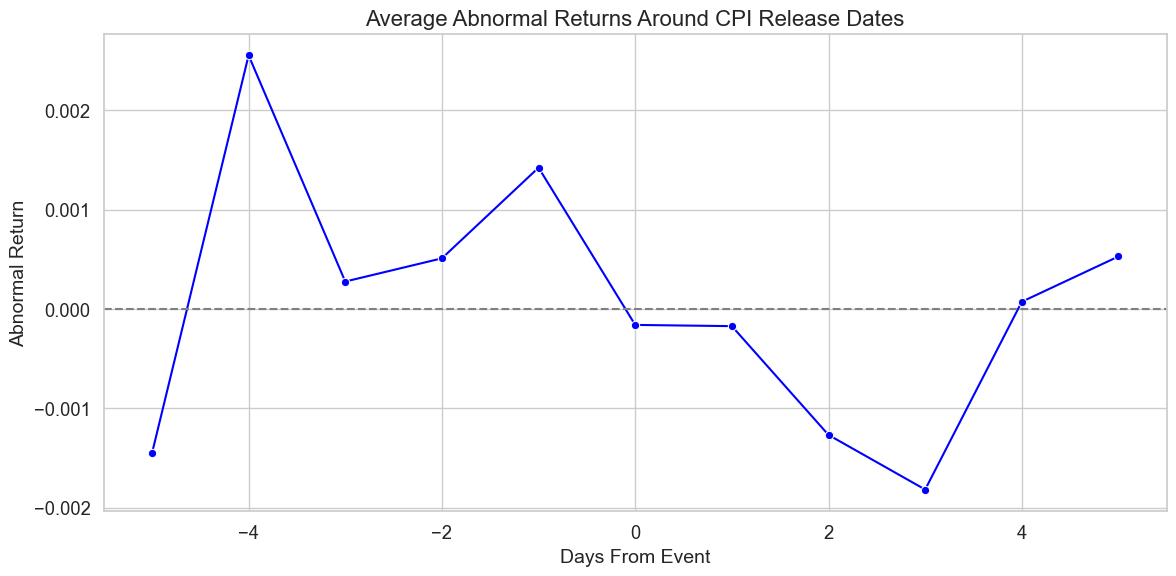

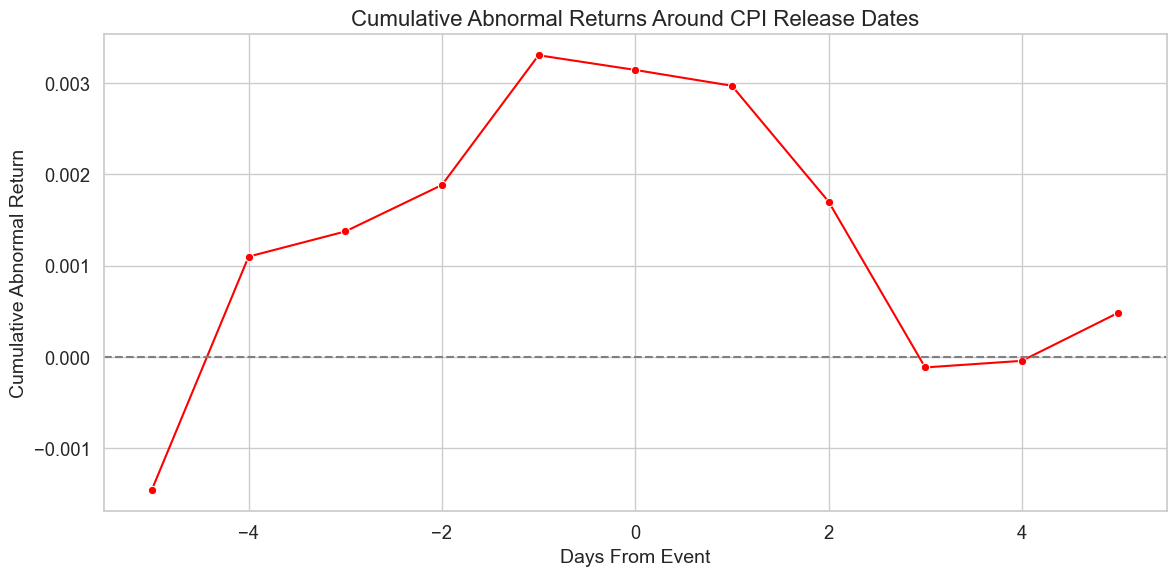

Window Size: 5, CPI Releases:
AAR: 0.0000, T-Statistic: 0.0322, P-Value: 0.9743, Confidence Interval: -0.0026, 0.0027
CAR: 0.1446, T-Statistic: 0.1157, P-Value: 0.9079, Confidence Interval: -2.3048, 2.5941


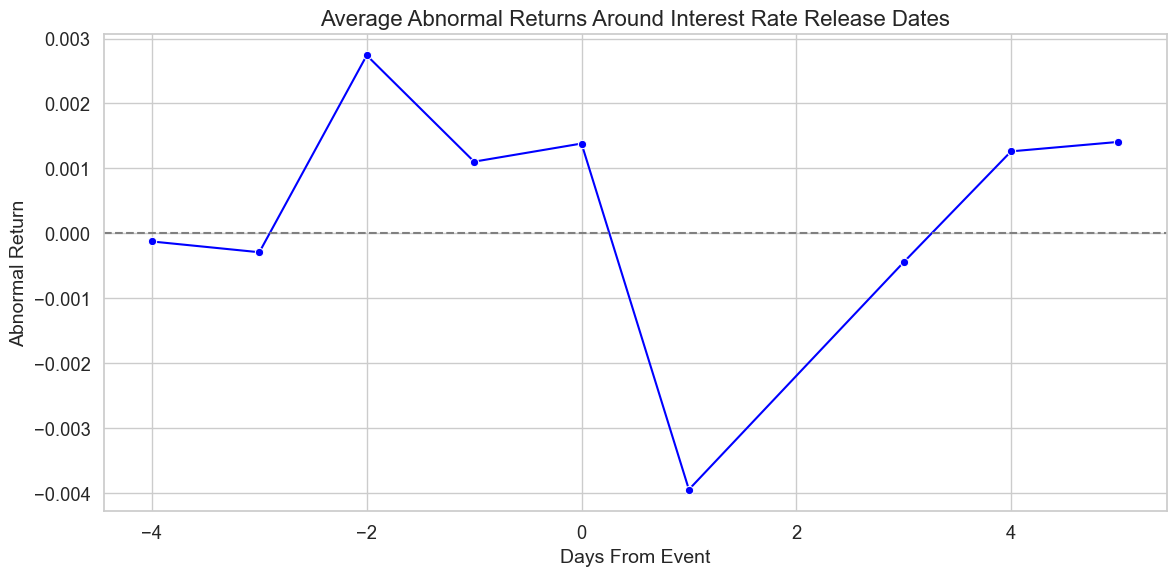

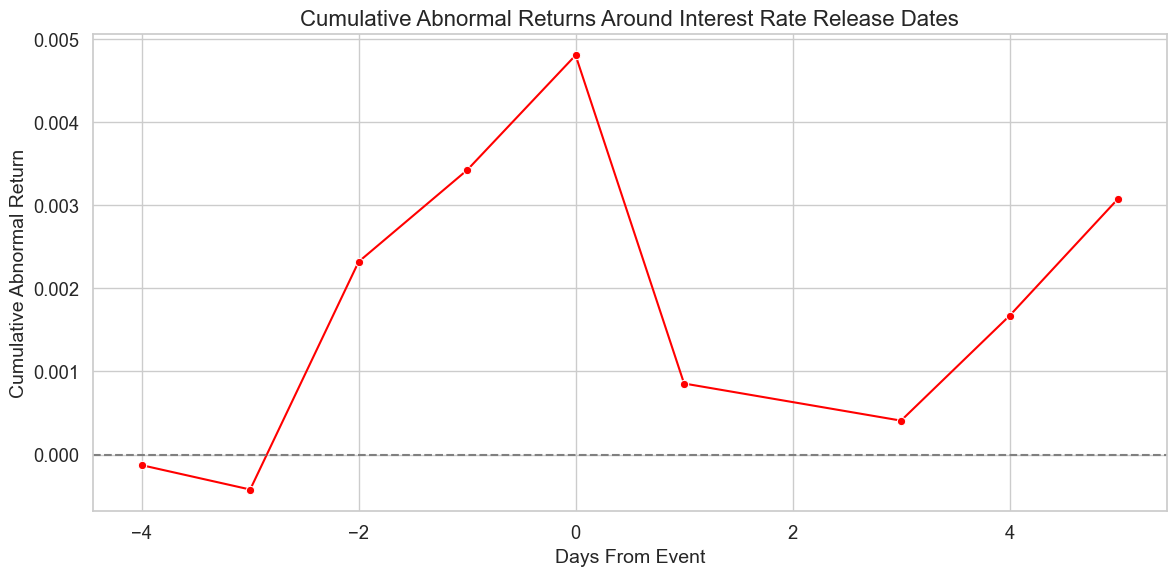

Window Size: 5, Interest Rate Releases:
AAR: 0.0003, T-Statistic: 0.2465, P-Value: 0.8053, Confidence Interval: -0.0024, 0.0031
CAR: 0.4021, T-Statistic: 0.3349, P-Value: 0.7377, Confidence Interval: -1.9514, 2.7556


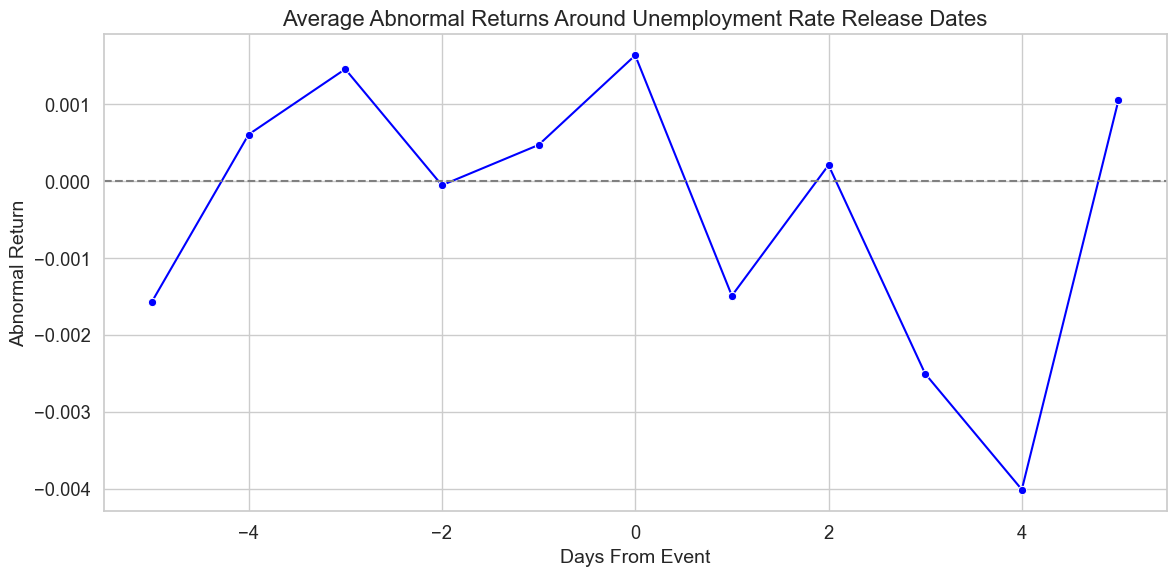

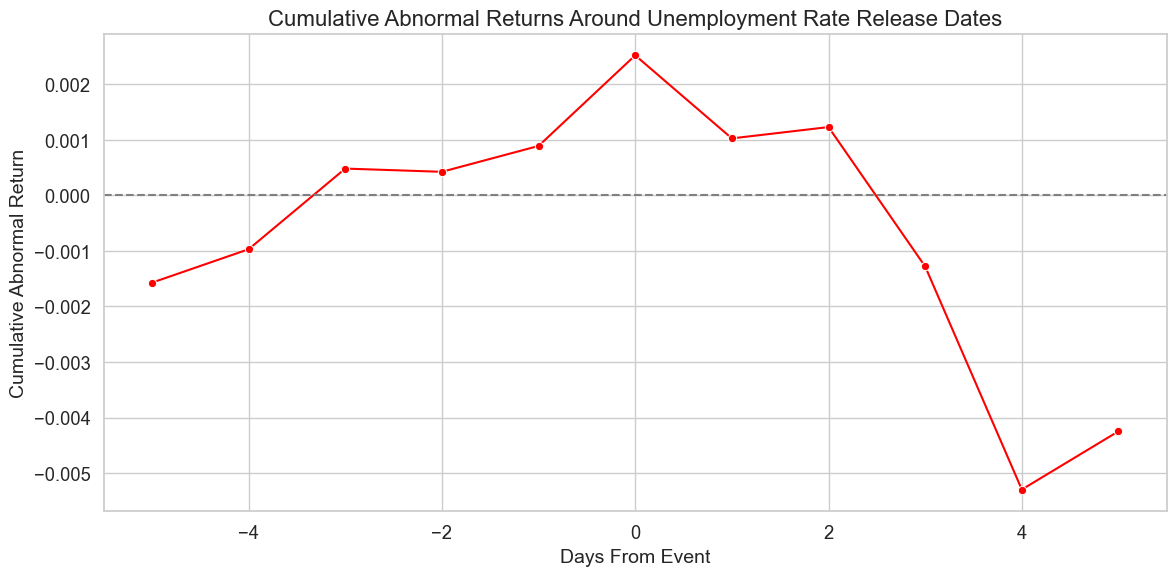

Window Size: 5, Unemployment Rate Releases:
AAR: -0.0004, T-Statistic: -0.2403, P-Value: 0.8101, Confidence Interval: -0.0035, 0.0028
CAR: -0.1007, T-Statistic: -0.0778, P-Value: 0.9380, Confidence Interval: -2.6380, 2.4366


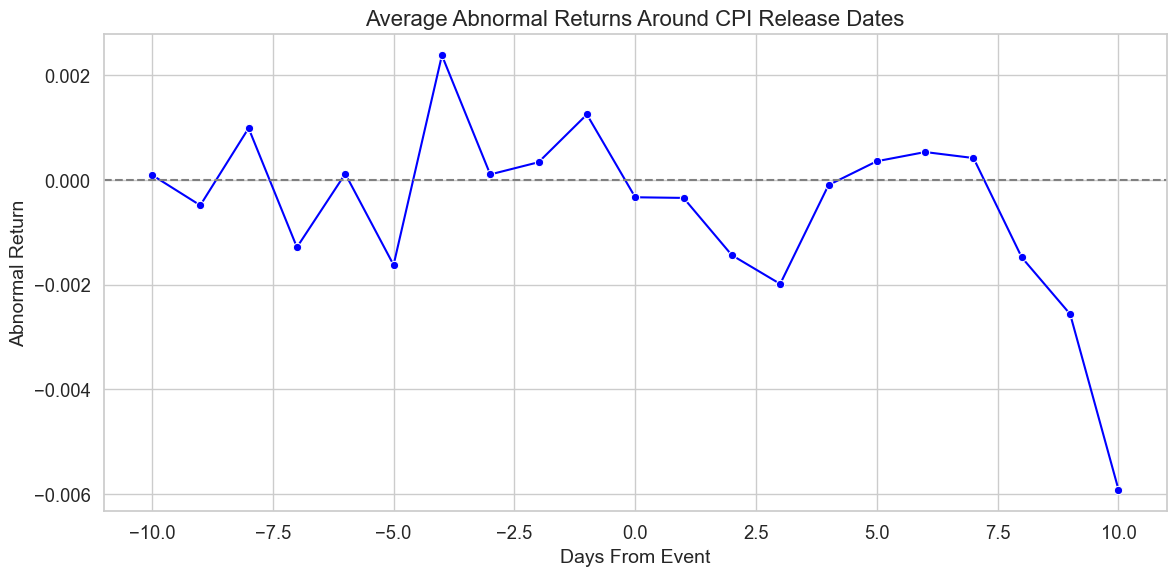

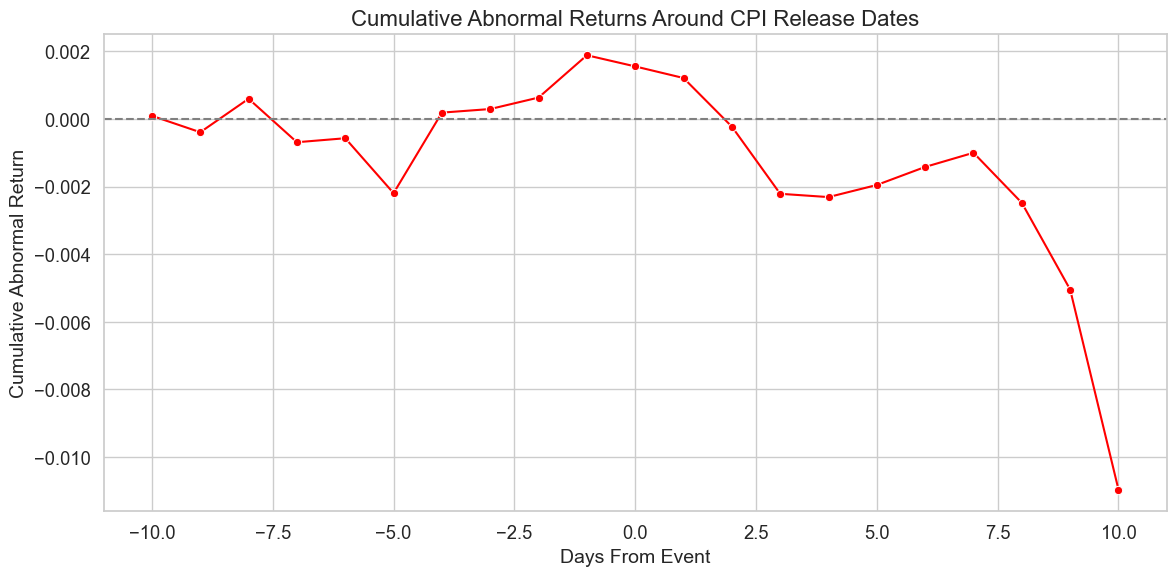

Window Size: 10, CPI Releases:
AAR: -0.0005, T-Statistic: -0.3939, P-Value: 0.6937, Confidence Interval: -0.0031, 0.0021
CAR: -0.2612, T-Statistic: -0.2076, P-Value: 0.8355, Confidence Interval: -2.7272, 2.2048


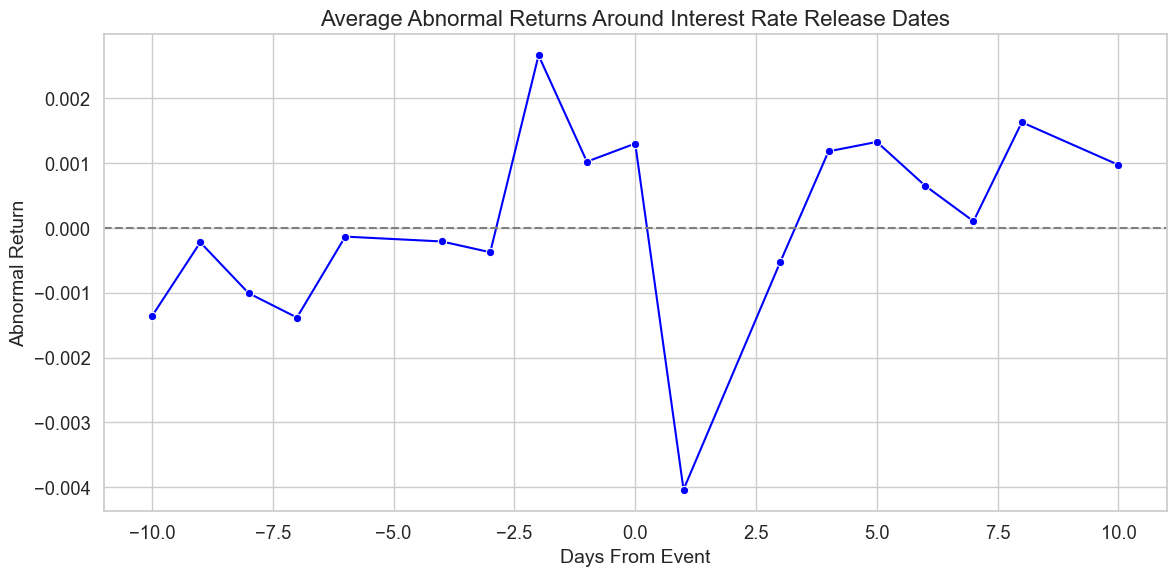

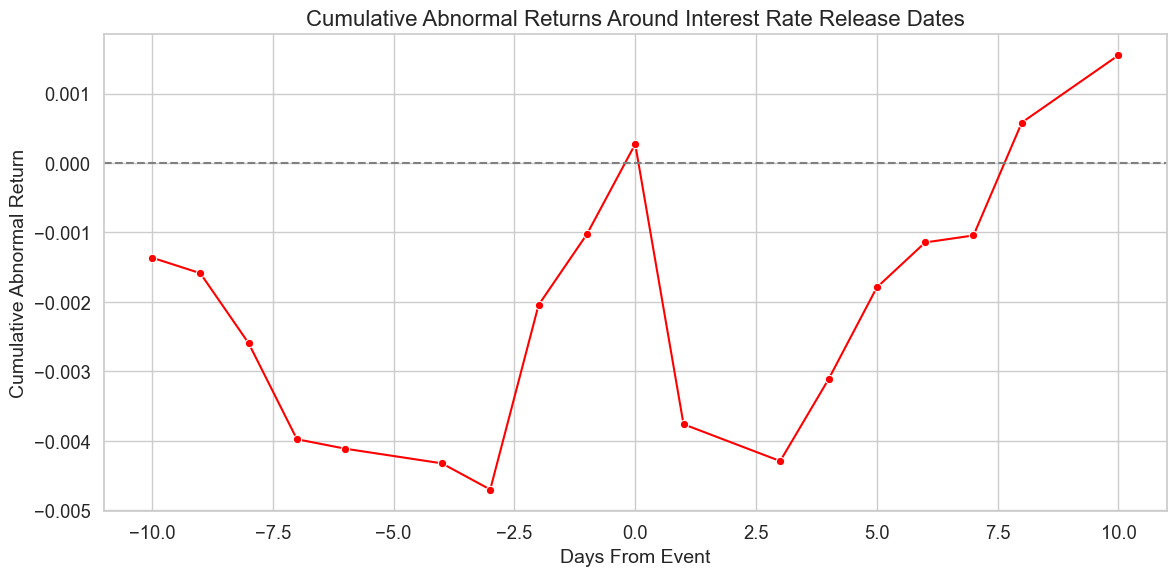

Window Size: 10, Interest Rate Releases:
AAR: 0.0001, T-Statistic: 0.0625, P-Value: 0.9502, Confidence Interval: -0.0026, 0.0028
CAR: 0.2015, T-Statistic: 0.1684, P-Value: 0.8663, Confidence Interval: -2.1445, 2.5475


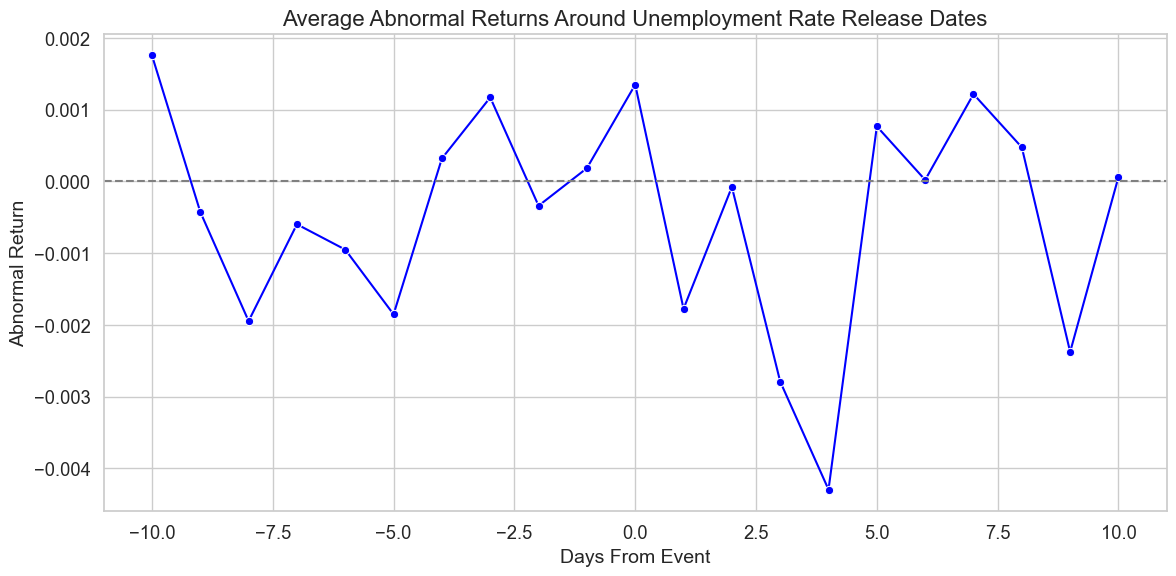

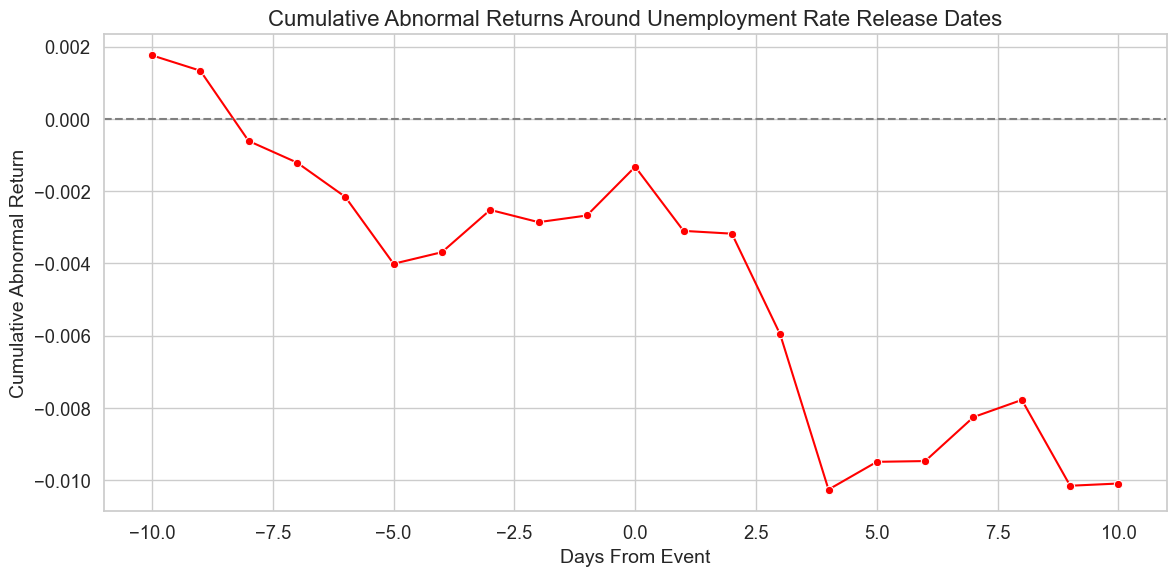

Window Size: 10, Unemployment Rate Releases:
AAR: -0.0005, T-Statistic: -0.3242, P-Value: 0.7458, Confidence Interval: -0.0034, 0.0024
CAR: -0.7726, T-Statistic: -0.5876, P-Value: 0.5568, Confidence Interval: -3.3497, 1.8046


In [45]:
# Define multiple event window sizes (days before and after the event)
event_window_sizes = [5, 10]

# Dictionary to store results for each indicator and window size
event_study_results = {}

interpretations = []

# Perform event study for each window size and indicator
for window_size in event_window_sizes:
    event_study_results[window_size] = {}
    
    for indicator_name, indicator_dates in zip(['CPI', 'Interest Rate', 'Unemployment Rate'], 
                                       [cpi_release_dates, interest_rate_release_dates, unemployment_rate_release_dates]):
        aar, aar_t_statistic, aar_p_value, aar_ci, car, car_t_statistic, car_p_value, car_ci, event_windows = event_study(ftse100_data_cleaned,
                                                                                                                          indicator_dates,
                                                                                                                          indicator_name,
                                                                                                                          window_size)
        event_study_results[window_size][indicator_name] = {
            'aar': aar,
            'aar_t_statistic': aar_t_statistic, 
            'aar_p_value': aar_p_value,
            'aar_ci': aar_ci,
            'car': car,
            'car_t_statistic': car_t_statistic,
            'car_p_value': car_p_value,
            'car_ci': car_ci,
            'event_windows': event_windows
        }
        print(f"Window Size: {window_size}, {indicator_name} Releases:")
        print(f"AAR: {aar:.4f}, T-Statistic: {aar_t_statistic:.4f}, P-Value: {aar_p_value:.4f}, Confidence Interval: {aar_ci[0]:.4f}, {aar_ci[1]:.4f}")
        print(f"CAR: {car:.4f}, T-Statistic: {car_t_statistic:.4f}, P-Value: {car_p_value:.4f}, Confidence Interval: {car_ci[0]:.4f}, {car_ci[1]:.4f}")

        interpretation = interpret_results(aar, aar_t_statistic, aar_p_value, aar_ci,
                                           car, car_t_statistic, car_p_value, car_ci,
                                           indicator_name, window_size)
        interpretations.append((window_size, indicator_name, interpretation))

### 3.2. Visualise results

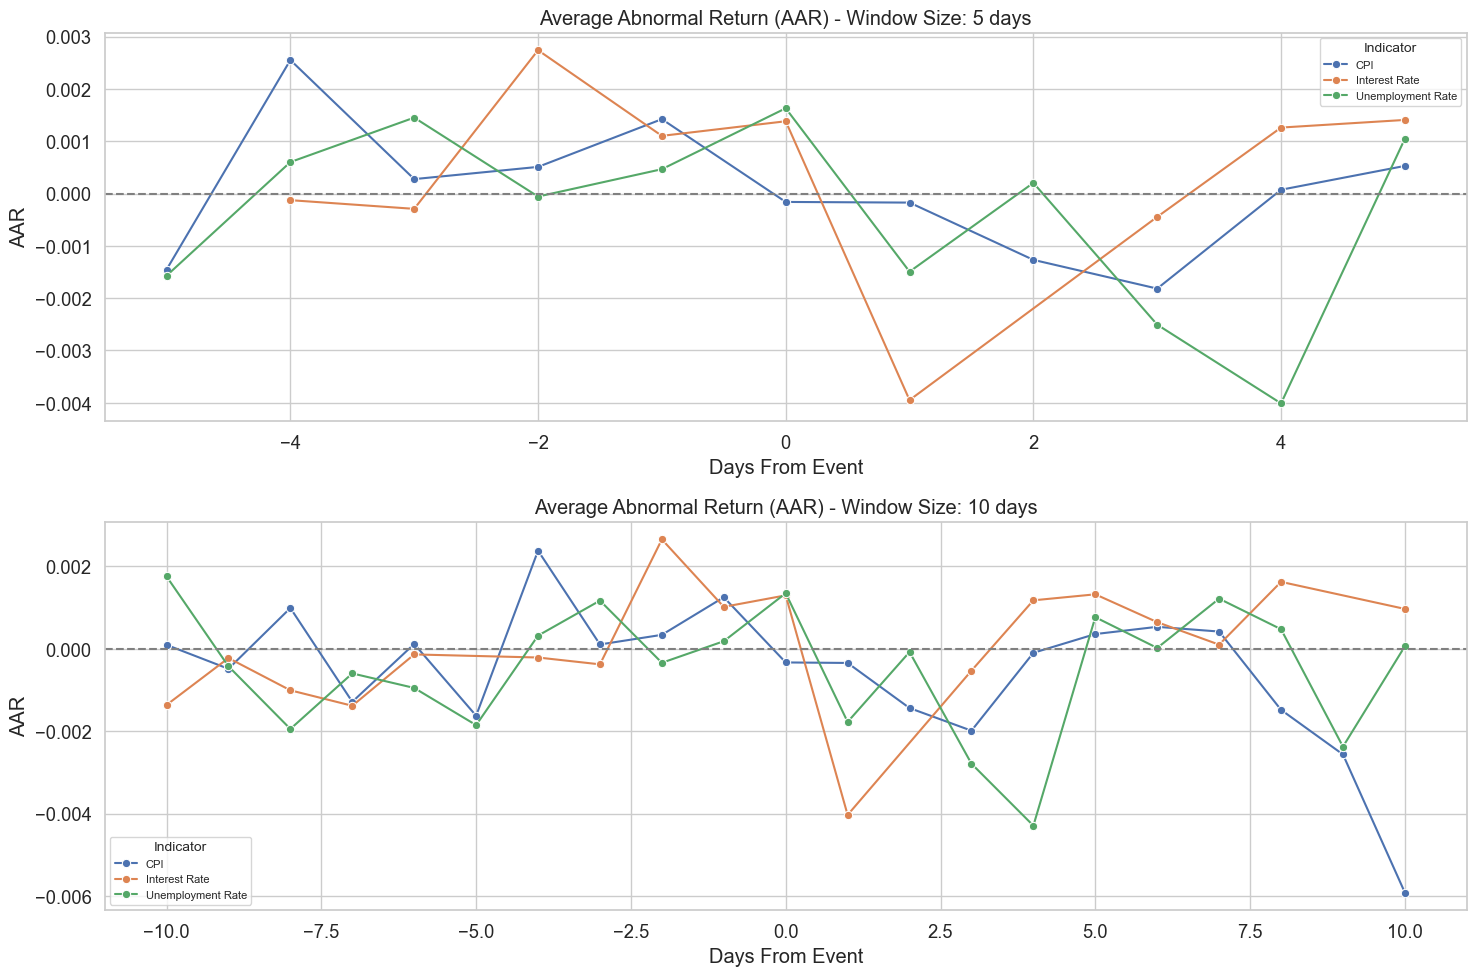

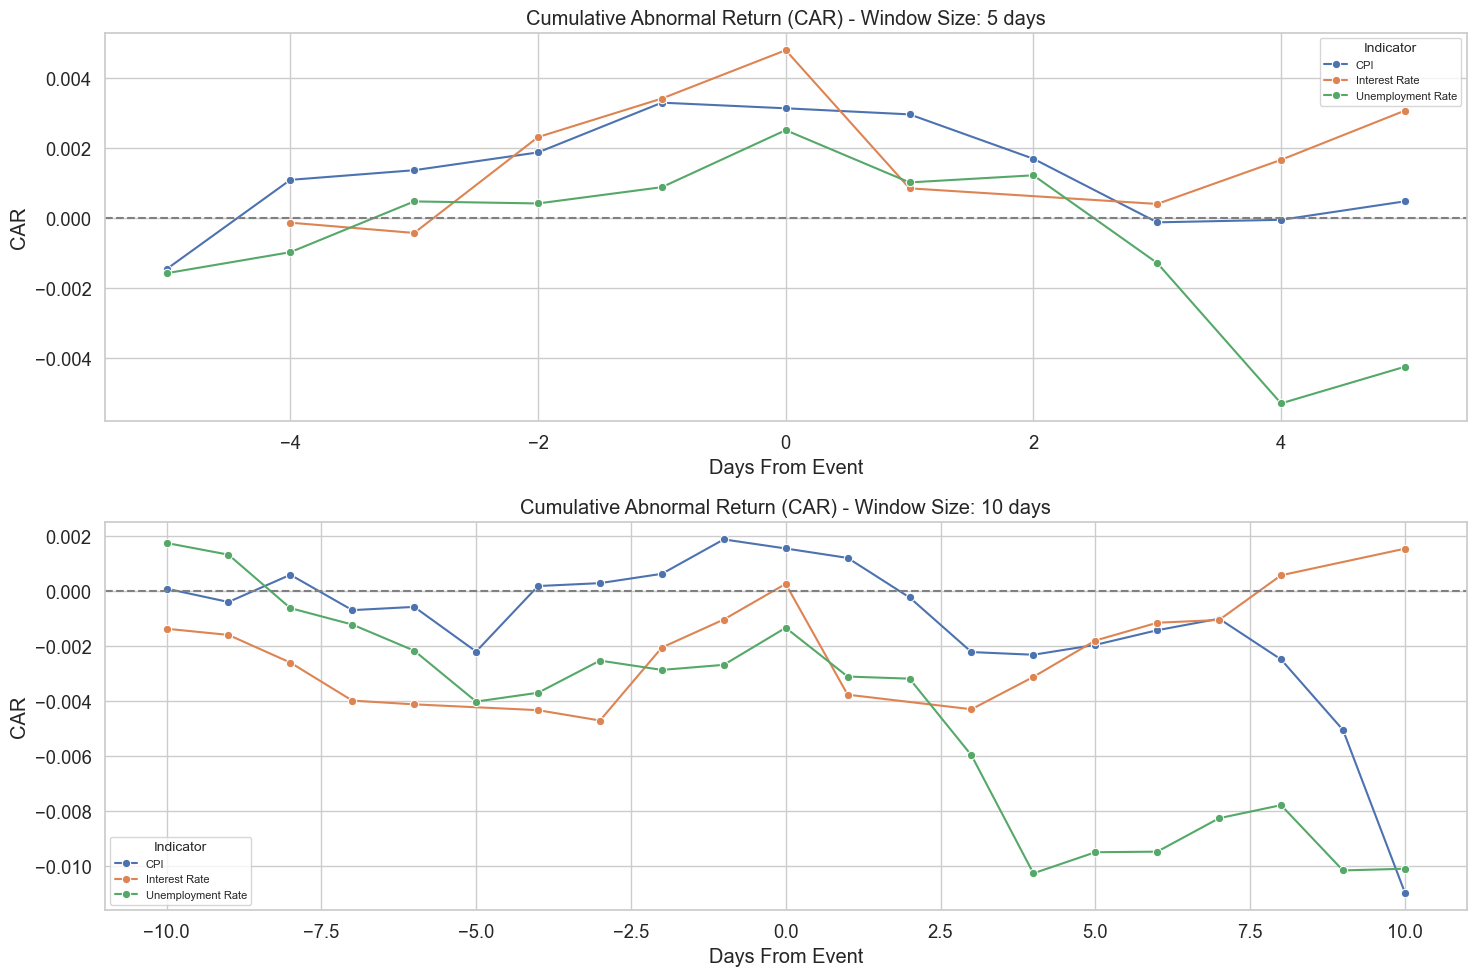

In [39]:
# Plot AAR for different window sizes
plot_aar_multiple_windows({window_size: {indicator: data['event_windows'] for indicator, data in indicators.items()}
                           for window_size, indicators in event_study_results.items()})

# Plot CAR for different window sizes
plot_car_multiple_windows({window_size: {indicator: data['event_windows'] for indicator, data in indicators.items()}
                           for window_size, indicators in event_study_results.items()})


### 3.3. Present findings

#### Create and display the summary table

In [40]:
summary_table = create_summary_table(event_study_results)
styled_summary = style_dataframe(summary_table.set_index(['Window Size', 'Indicator']))
display(HTML("<h3>Summary of Event Study Results</h3>"))
display(styled_summary)

#### Create and display the interpretation DataFrame

In [41]:
interpretation_df = create_interpretation_dataframe(interpretations)
styled_interpretation = style_interpretation_dataframe(interpretation_df)
display(HTML("<h3>Interpretations of Event Study Results</h3>"))
display(styled_interpretation)